In [4]:
import os
print(os.listdir('.'))

['requirements.txt', 'utils', 'README.md', '.gitignore', 'static', 'lectures', '.git', 'run_local_colab.sh', 'notebooks']


In [5]:
# Choose basedir as either local or hosted directory
import os
if "COLAB_BACKEND_VERSION" in os.environ:
    base_dir = "/content"
else:
    base_dir = os.getcwd()

work_dir = os.path.join(base_dir, "lectures")
if os.path.exists(work_dir):
    %cd $work_dir

import torch
import numpy as np

import copy
import random

from collections import defaultdict
from sklearn.model_selection import train_test_split

try:
    from utils.plotting import *  # see plotting.py for plotting utilities
    
except ModuleNotFoundError as e:
    if os.path.isdir(os.path.join(base_dir, "lectures")):
        raise e
    else:
        print("Cloning helper repo")
        !git clone https://github.com/cs449f24/lectures.git $work_dir
        %cd $work_dir
        !git pull -q origin main
        from utils.plotting import *

/Users/zach/Library/CloudStorage/OneDrive-NorthwesternUniversity/CS449F24/Lectures/lectures_github/notebooks/lectures/lectures


/Users/zach/miniconda3/envs/cs449/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from collections import defaultdict

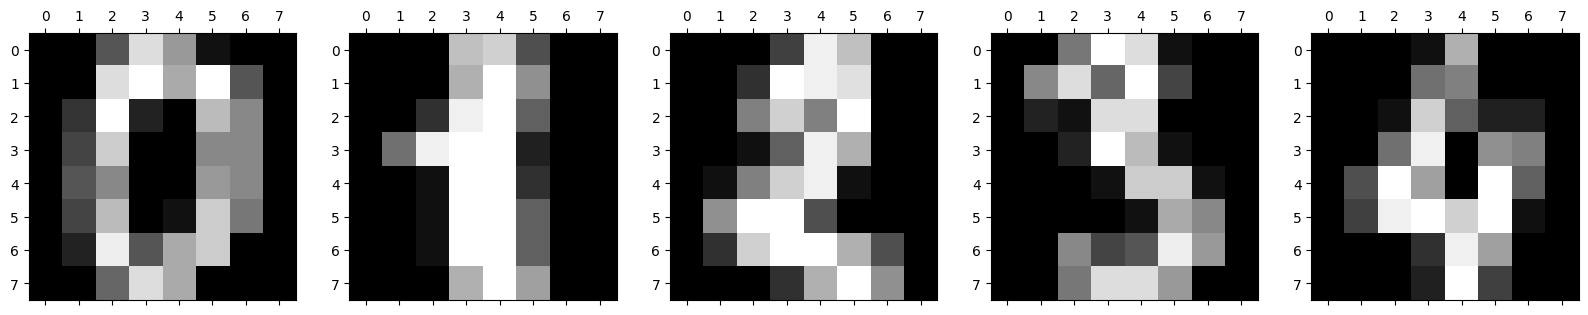

In [7]:
X, y = load_digits(return_X_y=True)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True,)
plt.gray()
for i, axis in enumerate(axes):
    axis.matshow(X[i, :].reshape(8, 8))
plt.show()

In [8]:
class CNN(torch.nn.Module):
    def __init__(self, linear_layer_size):
        super(CNN, self).__init__()
        self.linear_layer_size = linear_layer_size

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 16, kernel_size=2)
        self.linear = torch.nn.Linear(linear_layer_size, 10)

    def forward(self, x):
        batch_size = x.size(0)

        relu = torch.nn.ReLU()
        maxpool = torch.nn.MaxPool2d(kernel_size=2)

        x = self.conv1(x)
        x = maxpool(relu(x))

        x = self.conv2(x)
        x = maxpool(relu(x))

        x = x.reshape(batch_size, self.linear_layer_size)
        x = self.linear(x)
        return x

In [9]:
def print_model(model):
    """ 
    A simple functon that prints out a PyTorch model's structural details
    """
    # Print the number of parameters in the model
    parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("In total, this network has ", parameter_count, " parameters")

In [10]:
def run_one_epoch(model, optimizer, X, y, train=True):

    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    acc = torch.sum(torch.argmax(output, dim=1) == y) / y.size(0)
    loss = torch.nn.CrossEntropyLoss()(output, y)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

In [11]:
def numpy_to_tensor(lst):
    """
    Convert numpy array to torch tensor
    """
    if type(lst) == np.ndarray:
        return torch.tensor(lst).to(dtype=torch.float32)

    else:
        out = [torch.tensor(item).to(dtype=torch.float32) for item in lst]
        return tuple(out)

X, y = load_digits(return_X_y=True)
X = torch.tensor(X.reshape(-1, 1, 8, 8)).to(dtype=torch.float32)
y = torch.tensor(y).to(dtype=torch.long)
mnist = train_test_split(X, y, test_size=0.2)
print("train:", mnist[0].shape)
print("test: ", mnist[1].shape)

train: torch.Size([1437, 1, 8, 8])
test:  torch.Size([360, 1, 8, 8])


In [12]:
def demo(model, data, n_epochs=100, verbose=False):
    X_train, X_test, y_train, y_test = data
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    results = defaultdict(list)
    for i in range(n_epochs):
        train_acc, train_loss = run_one_epoch(model, optimizer, X_train, y_train, train=True)
        test_acc, test_loss = run_one_epoch(model, optimizer, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        if verbose and (i + 1) % (n_epochs // 10) == 0:
            train_stats = f"Train loss: {train_loss:.3f} Train accuracy: {100 * train_acc:4.1f}%"
            test_stats = f"Test loss: {test_loss:.3f} Test accuracy: {100 * test_acc:.1f}%"
            print(f"{i + 1:4d} {train_stats} {test_stats}")

    return results


def plot(results):    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                             constrained_layout=True)

    ax = axes[0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    plt.show()

In total, this network has  2394  parameters
  10 Train loss: 2.299 Train accuracy: 15.1% Test loss: 2.256 Test accuracy: 19.2%
  20 Train loss: 2.118 Train accuracy: 22.4% Test loss: 2.080 Test accuracy: 27.2%
  30 Train loss: 1.935 Train accuracy: 40.7% Test loss: 1.896 Test accuracy: 40.6%
  40 Train loss: 1.758 Train accuracy: 47.1% Test loss: 1.711 Test accuracy: 48.9%
  50 Train loss: 1.552 Train accuracy: 56.6% Test loss: 1.504 Test accuracy: 56.1%
  60 Train loss: 1.352 Train accuracy: 64.7% Test loss: 1.311 Test accuracy: 65.8%
  70 Train loss: 1.149 Train accuracy: 74.0% Test loss: 1.121 Test accuracy: 71.1%
  80 Train loss: 0.967 Train accuracy: 77.6% Test loss: 0.949 Test accuracy: 76.1%
  90 Train loss: 0.821 Train accuracy: 81.4% Test loss: 0.810 Test accuracy: 78.6%
 100 Train loss: 0.705 Train accuracy: 84.2% Test loss: 0.702 Test accuracy: 81.4%


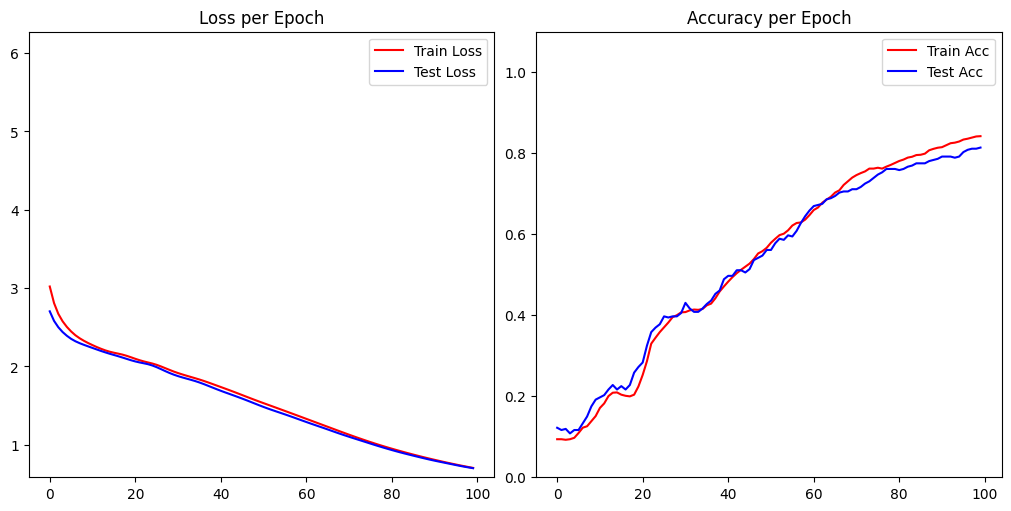

In [13]:
model = CNN(linear_layer_size=16)
print_model(model)
results = demo(model, mnist, 100, verbose=True)
plot(results)

In [14]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, activation=torch.tanh):
        super().__init__()

        self.input_dim = input_dim
        self.layer1 = torch.nn.Linear(input_dim, 32)
        self.layer2 = torch.nn.Linear(32, 16)
        self.layer3 = torch.nn.Linear(16, 10)
        self.activation = activation
        
        for layer in [self.layer1, self.layer2, self.layer3]:
          torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):

        x = x.reshape(-1, self.input_dim)

        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In total, this network has  2778  parameters
  10 Train loss: 2.215 Train accuracy: 18.8% Test loss: 2.206 Test accuracy: 18.1%
  20 Train loss: 1.938 Train accuracy: 32.9% Test loss: 1.946 Test accuracy: 28.9%
  30 Train loss: 1.739 Train accuracy: 50.6% Test loss: 1.763 Test accuracy: 47.5%
  40 Train loss: 1.555 Train accuracy: 64.6% Test loss: 1.599 Test accuracy: 60.8%
  50 Train loss: 1.398 Train accuracy: 70.5% Test loss: 1.449 Test accuracy: 66.9%
  60 Train loss: 1.257 Train accuracy: 73.9% Test loss: 1.313 Test accuracy: 73.1%
  70 Train loss: 1.132 Train accuracy: 78.7% Test loss: 1.191 Test accuracy: 75.6%
  80 Train loss: 1.019 Train accuracy: 83.2% Test loss: 1.078 Test accuracy: 79.7%
  90 Train loss: 0.916 Train accuracy: 86.1% Test loss: 0.975 Test accuracy: 82.8%
 100 Train loss: 0.825 Train accuracy: 88.2% Test loss: 0.885 Test accuracy: 85.3%


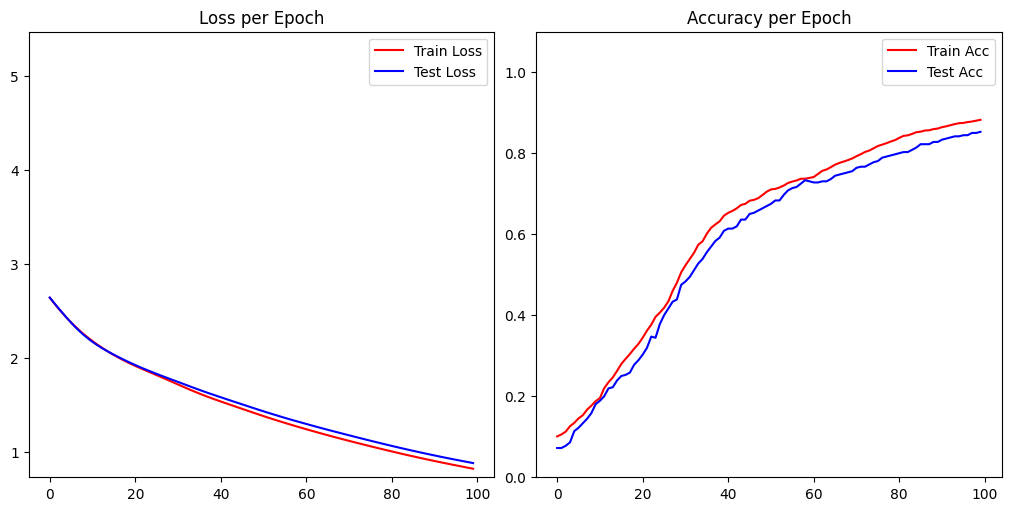

In [15]:
model = Net(64)
print_model(model)
results = demo(model, mnist, 100, verbose=True)
plot(results)

In [18]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
n_train = 1437
n_test = 360


X_train = train_data.data[:n_train].to(dtype=torch.float)
X_train = X_train.reshape(n_train, 1, 28, 28)
y_train = train_data.targets[:n_train].to(dtype=torch.long)

X_test = test_data.data[:n_test].to(dtype=torch.float)
X_test = X_test.reshape(n_test, 1, 28, 28)
y_test = test_data.targets[:n_test].to(dtype=torch.long)

large_mnist = (X_train, X_test, y_train, y_test)
print("train:", large_mnist[0].shape)
print("test: ", large_mnist[1].shape)

train: torch.Size([1437, 1, 28, 28])
test:  torch.Size([360, 1, 28, 28])


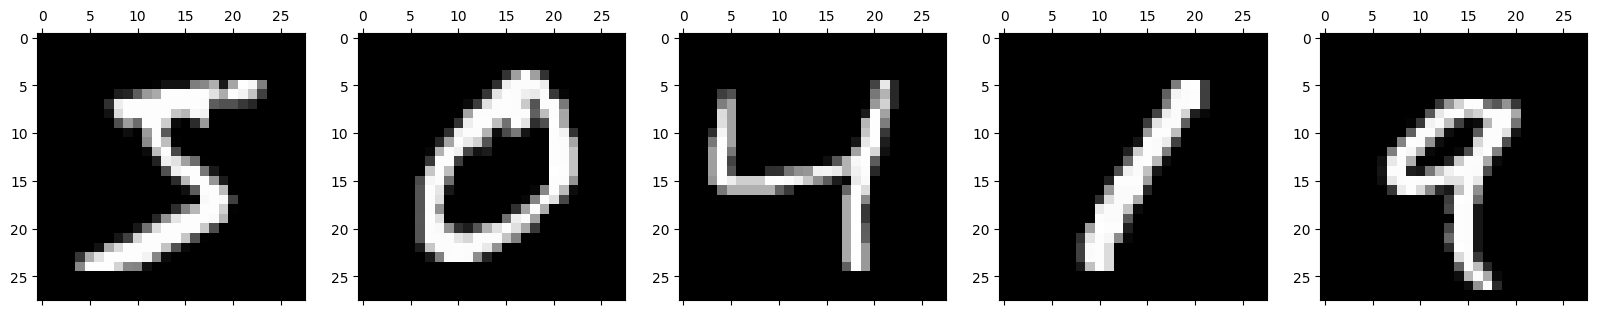

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True,)
plt.gray()
for i, axis in enumerate(axes):
    axis.matshow(large_mnist[0][i, :].reshape(28, 28))
plt.show()

In total, this network has  7994  parameters
  10 Train loss: 5.136 Train accuracy: 33.5% Test loss: 4.694 Test accuracy: 33.3%
  20 Train loss: 1.943 Train accuracy: 55.3% Test loss: 2.140 Test accuracy: 50.6%
  30 Train loss: 1.145 Train accuracy: 65.9% Test loss: 1.277 Test accuracy: 61.1%
  40 Train loss: 0.810 Train accuracy: 76.1% Test loss: 1.021 Test accuracy: 68.1%
  50 Train loss: 0.601 Train accuracy: 81.9% Test loss: 0.865 Test accuracy: 73.6%
  60 Train loss: 0.459 Train accuracy: 86.4% Test loss: 0.745 Test accuracy: 76.7%
  70 Train loss: 0.352 Train accuracy: 90.0% Test loss: 0.654 Test accuracy: 79.2%
  80 Train loss: 0.271 Train accuracy: 92.7% Test loss: 0.594 Test accuracy: 81.7%
  90 Train loss: 0.211 Train accuracy: 94.4% Test loss: 0.564 Test accuracy: 84.4%
 100 Train loss: 0.164 Train accuracy: 96.0% Test loss: 0.546 Test accuracy: 84.4%


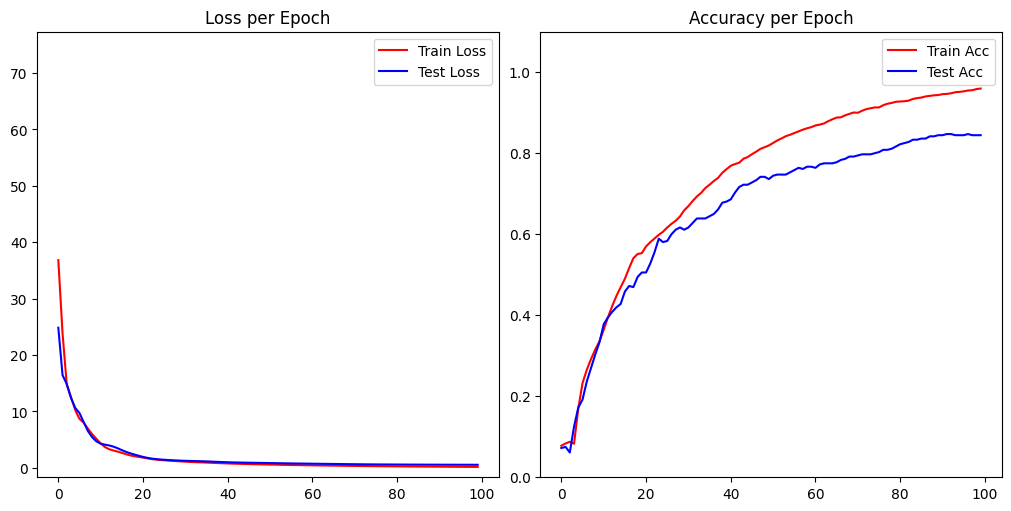

In [20]:
model = CNN(linear_layer_size=576)
print_model(model)
results = demo(model, large_mnist, 100, verbose=True)
plot(results)

In total, this network has  25818  parameters
  10 Train loss: 1.981 Train accuracy: 32.3% Test loss: 1.998 Test accuracy: 30.8%
  20 Train loss: 1.698 Train accuracy: 50.5% Test loss: 1.773 Test accuracy: 45.8%
  30 Train loss: 1.505 Train accuracy: 59.4% Test loss: 1.626 Test accuracy: 51.4%
  40 Train loss: 1.367 Train accuracy: 64.9% Test loss: 1.531 Test accuracy: 54.2%
  50 Train loss: 1.249 Train accuracy: 71.4% Test loss: 1.443 Test accuracy: 59.4%
  60 Train loss: 1.151 Train accuracy: 74.7% Test loss: 1.377 Test accuracy: 60.6%
  70 Train loss: 1.064 Train accuracy: 77.0% Test loss: 1.314 Test accuracy: 63.6%
  80 Train loss: 0.984 Train accuracy: 80.4% Test loss: 1.258 Test accuracy: 65.8%
  90 Train loss: 0.916 Train accuracy: 82.0% Test loss: 1.210 Test accuracy: 66.4%
 100 Train loss: 0.856 Train accuracy: 82.9% Test loss: 1.150 Test accuracy: 67.8%


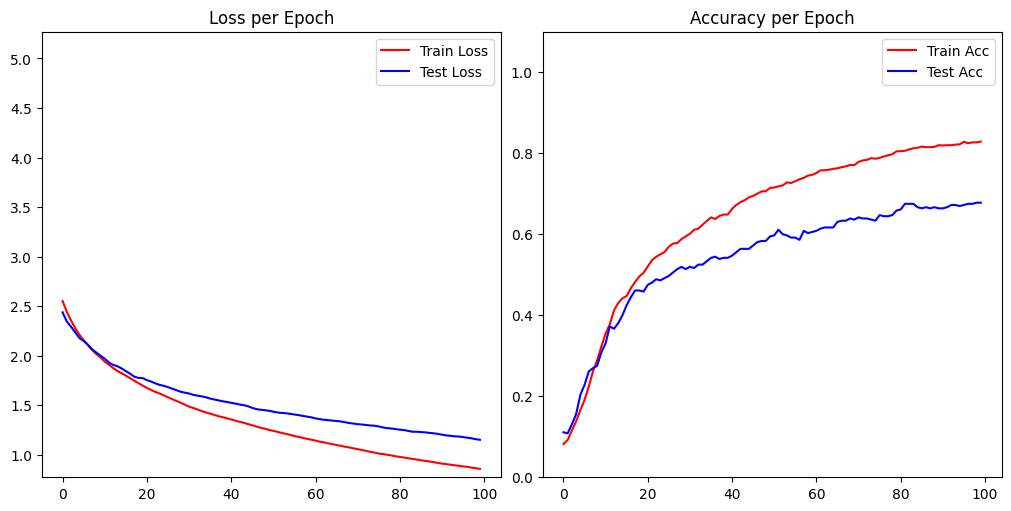

In [21]:
model = Net(784)
print_model(model)
results = demo(model, large_mnist, 100, verbose=True)
plot(results)